In [7]:
import sys

sys.executable

'/Applications/anaconda3/bin/python'

In [14]:
import numpy as np
import pandas as pd
# from numpy import cos, sin, pi
# from scipy.optimize import minimize, fmin
import pandas as pd
import os
package_path = '../'
if package_path is not None:
    os.sys.path.append(package_path)

    
import json,yaml
import matplotlib.pyplot as plt
from time import sleep
from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm

import matplotlib
%matplotlib inline

# some setting for the plots
font = {
#     'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('lines', linewidth=2)
matplotlib.rc('font', **font)


# auto reload external files, so that we can edit the external .py file and inmediately see the changes here
%load_ext autoreload
%autoreload 2


from frozen_dipole_model import frozen_dipole_model 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1) calculate the frequencies and equilibrium positions
using the python code

In [11]:
physical_parameters = frozen_dipole_model.default_physical_parameters
parameters = frozen_dipole_model.get_parameters(physical_parameters)
# # define ho in um
# ho = np.arange(30, 150, 5)
# to = np.arange(-np.pi, np.pi, 0.25)

# define ho in um
ho = np.arange(30, 150, 1)
to = np.arange(0, np.pi, 0.025)

normalization = 'a' # choose normalization z hI or acrit (acrit doesn't work so well because of numerics)

len(ho), len(to)

X, Y = np.meshgrid(ho/parameters[normalization]*1e-6, to)
shape = X.shape

position_eq, frequencies = [], []
step = 10
N_steps = len(X.flatten())
with tqdm(total=N_steps, file=sys.stdout) as pbar:    
    for i, (x, y) in enumerate(zip(X.flatten(), Y.flatten())):
#         if i % step==0:
#             print(i, '/', N_steps)
        pbar.set_description('processed: %d' % (1 + i))
        pbar.update(step)
        f, eq  = frozen_dipole_model.frequencies(ho=x, to=y, physical_parameters=physical_parameters,
                                                 set_y_phi_zero=True, normalization= normalization, return_eq_positions=True)
        frequencies.append(f)
        position_eq.append(eq)

#         sleep(0.1)

    
position_eq = np.array(position_eq)

frequencies = np.array(frequencies)

# normalize to physical units
if position_eq.shape[1]==3:
    position_eq[:,0:2]*=parameters[normalization]*1e6  # um
# normalize to physical units
elif position_eq.shape[1]==5:
    position_eq[:,0:3]*=parameters[normalization]*1e6  # um
else:
    print('something is wrong!')
X, Y = np.meshgrid(ho, to)
Y /=np.pi

processed: 113:   7%|▋         | 1120/15120 [00:08<01:08, 205.11it/s]

../frozen_dipole_model/frozen_dipole_model.py:314: RuntimeWarning: invalid value encountered in sqrt
  eigen_frequencies = np.sqrt(Us*eigen_values)/(2*np.pi)
../frozen_dipole_model/frozen_dipole_model.py:314: RuntimeWarning: invalid value encountered in sqrt
  eigen_frequencies = np.sqrt(Us*eigen_values)/(2*np.pi)


processed: 122:   8%|▊         | 1210/15120 [00:08<01:03, 220.40it/s]

../frozen_dipole_model/frozen_dipole_model.py:314: RuntimeWarning: invalid value encountered in sqrt
  eigen_frequencies = np.sqrt(Us*eigen_values)/(2*np.pi)
../frozen_dipole_model/frozen_dipole_model.py:314: RuntimeWarning: invalid value encountered in sqrt
  eigen_frequencies = np.sqrt(Us*eigen_values)/(2*np.pi)
../frozen_dipole_model/frozen_dipole_model.py:314: RuntimeWarning: invalid value encountered in sqrt
  eigen_frequencies = np.sqrt(Us*eigen_values)/(2*np.pi)


processed: 15120: : 151200it [20:19, 192.30it/s]


### save data

In [39]:
tag = 'frozen_dipole_a=22.5um'


df = pd.DataFrame(data = np.hstack([X.reshape(-1,1), Y.reshape(-1,1), position_eq, frequencies]),
            columns = ['$h_0$ (um)', '$\\theta_0$ (rad)', 'x_eq (um)', 'z_eq (um)', 't_eq (rad)'] + ['$f_{:d}$ (Hz)'.format(i) for i in range(5)])
df.to_csv('../data/{:s}.csv'.format(tag))  # save data

with open('../data/{:s}.json'.format(tag), 'w') as outfile:
    tmp = json.dump(physical_parameters, outfile, indent=4)
    


### load data

In [251]:
tag = 'frozen_dipole_a=22.5um'

with open('../data/{:s}.json'.format(tag), 'r') as infile:
    physical_parameters = yaml.safe_load(infile)
df = pd.read_csv('../data/{:s}.csv'.format(tag), index_col=0)

#### reorder f1 and f4

In [252]:

for h in df['$h_0$ (um)'].unique():
    
    sub_df = df[df['$h_0$ (um)'] == h]
    # look for jumps in f1
    t_max = sub_df['$\\theta_0$ (rad)'].iloc[np.argmax(np.diff(sub_df['$f_1$ (Hz)'].dropna()))]
    t_min = sub_df['$\\theta_0$ (rad)'].iloc[np.argmin(np.diff(sub_df['$f_1$ (Hz)'].dropna()))]
    
#     view = ((df['$\\theta_0$ (rad)'] > t_max) | (df['$\\theta_0$ (rad)'] <= t_min) & df['$h_0$ (um)'] == h)
#     view1 = ((df['$\\theta_0$ (rad)'] > t_max) | (df['$\\theta_0$ (rad)'] <= t_min))
#     view2 = df['$h_0$ (um)'] == h
    
    view1 = (df['$\\theta_0$ (rad)'] > t_max) & (df['$h_0$ (um)'] == h)
    
    view2 = (df['$\\theta_0$ (rad)'] <= t_min) & (df['$h_0$ (um)'] == h)
    
    view = view1 | view2
    
    vals = df.loc[view, ['$f_1$ (Hz)', '$f_4$ (Hz)']].values
    df.loc[view, ['$f_4$ (Hz)', '$f_1$ (Hz)']] = vals

#### get data form data frame

In [253]:
X, Y = df[df.keys()[0]].values, df[df.keys()[1]].values
shape = (len(np.unique(Y)), len(np.unique(X)))
X = X.reshape(shape)
Y = Y.reshape(shape)
position_eq, frequencies = df[df.keys()[2:5]].values, df[df.keys()[5:]].values

### plot data

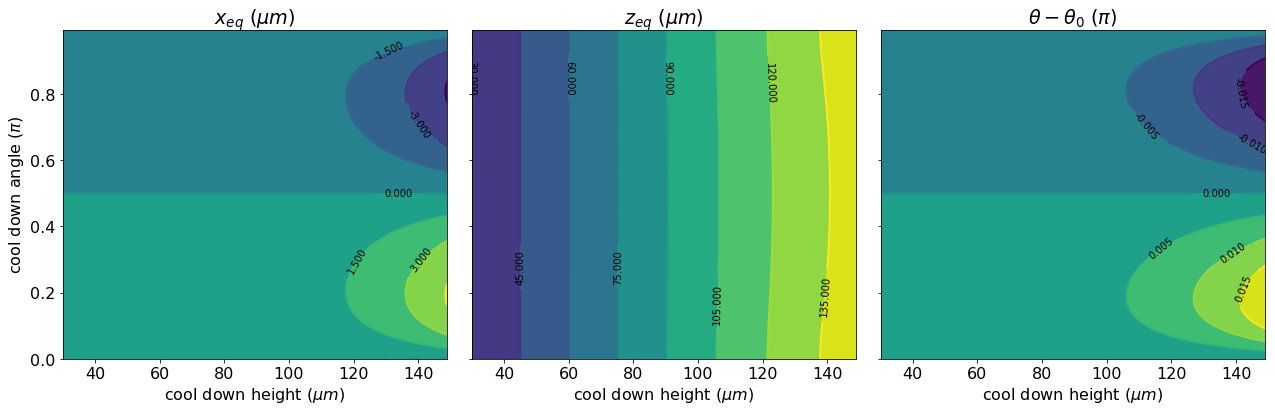

In [232]:

fig, axContour = plt.subplots(1,position_eq.shape[1], figsize=(18, 6), sharey=True)

    # create figure
for i, (ax, direction) in enumerate(zip(axContour, ['$x_{eq}$ ($\mu m$)', '$z_{eq}$ ($\mu m$)', '$\\theta-\\theta_0$ ($\pi$)'])):
    
    

    if i==2:
        Z = position_eq[:,i].reshape(shape)/np.pi-Y
    else:
        Z = position_eq[:,i].reshape(shape)

    
    # plot contour
    CS =ax.contour(X, Y, Z)
    ax.clabel(CS, inline=1, fontsize=10, colors='k')
    
#     CS =plt.pcolor(X, Y, Z)
    CS =ax.contourf(X, Y, Z)
#     cb = ax.colorbar()
#     cb.set_label(quantity)

        

    ax.set_xlabel('cool down height ($\mu m$)')
    ax.set_title(direction)
    if i==0:
        ax.set_ylabel('cool down angle ($\pi$)')

fig.tight_layout()
plt.draw()
plt.show()

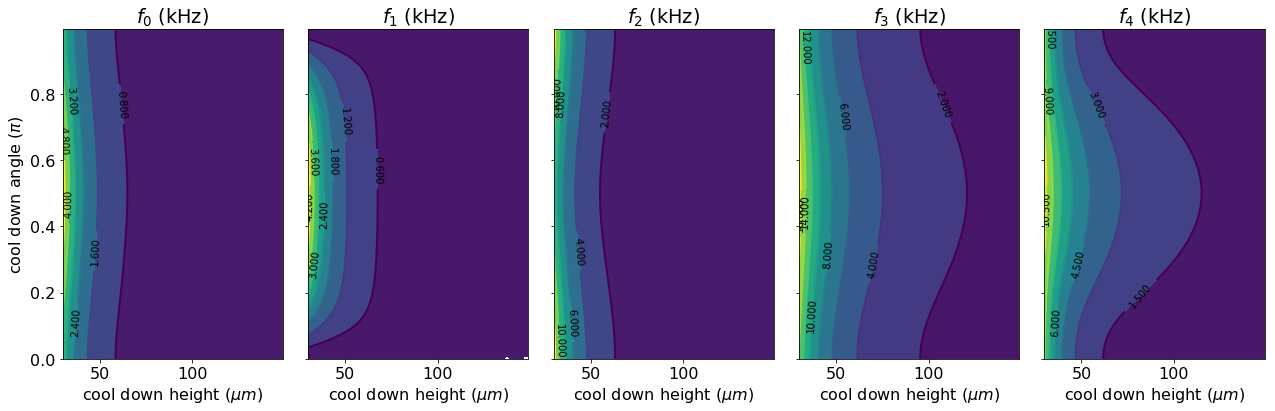

In [254]:

fig, axContour = plt.subplots(1,frequencies.shape[1], figsize=(18, 6), sharey=True)

    # create figure
for i, (ax, direction) in enumerate(zip(axContour, ['$f_{:d}$ (kHz)'.format(i) for i in range(5)])):
    
    
    Z = frequencies[:,i].reshape(shape)*1e-3

    
    # plot contour
    CS =ax.contour(X, Y, Z)
    ax.clabel(CS, inline=1, fontsize=10, colors='k')
    
#     CS =plt.pcolor(X, Y, Z)
    CS =ax.contourf(X, Y, Z)
#     cb = ax.colorbar()
#     cb.set_label(quantity)

        

    ax.set_xlabel('cool down height ($\mu m$)')
    ax.set_title(direction)
    if i==0:
        ax.set_ylabel('cool down angle ($\pi$)')

fig.tight_layout()
plt.draw()
plt.show()

In [271]:
df.keys()

Index(['$h_0$ (um)', '$\theta_0$ (rad)', 'x_eq (um)', 'z_eq (um)',
       't_eq (rad)', '$f_0$ (Hz)', '$f_1$ (Hz)', '$f_2$ (Hz)', '$f_3$ (Hz)',
       '$f_4$ (Hz)'],
      dtype='object')

(100, 150)

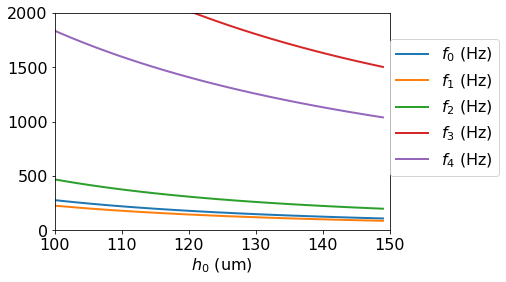

In [283]:
sub_df = df[df['$\\theta_0$ (rad)'] == df['$\\theta_0$ (rad)'].unique()[62]]

sub_df.plot(x='$h_0$ (um)', y=['$f_{:d}$ (Hz)'.format(i) for i in range(5)], legend=False)
plt.legend(loc = (1,0.25))
plt.ylim(0,2000)
plt.xlim(100,150)
# plt.plot(sub_df['theta_0 (rad)'], sub_df['$f_0$ (Hz)])

In [ ]:
sub_df = df[df['$h_0$ (um)'] == 60.0]

sub_df.plot(x='$\\theta_0$ (rad)', y=['$f_{:d}$ (Hz)'.format(i) for i in range(5)], legend=False)
plt.legend(loc = (1,0))
# plt.plot(sub_df['theta_0 (rad)'], sub_df['$f_0$ (Hz)])

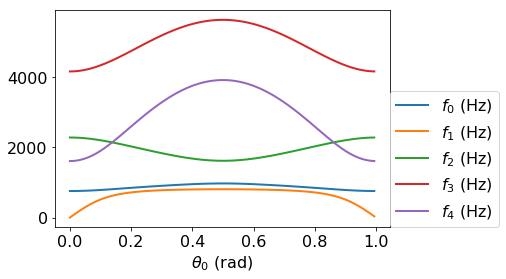

In [255]:
# df2 = df.iloc[1950-400:13230]#[['$f_1$ (Hz)', '$f_4$ (Hz)']]
df2 = df
# df2 =df

sub_df = df2[df2['$h_0$ (um)'] == 60.0]

# sub_df = sub_df[sub_df['$\\theta_0$ (rad)'] <= t_max]

# sub_df = sub_df[sub_df['$\\theta_0$ (rad)'] <= t_max]




# vals = sub_df.loc[sub_df['$\\theta_0$ (rad)'] > t_max, ['$f_4$ (Hz)', '$f_1$ (Hz)']] 
# sub_df.loc[sub_df['$\\theta_0$ (rad)'] > t_max, ['$f_1$ (Hz)', '$f_4$ (Hz)']] = vals.values
# vals = sub_df.loc[sub_df['$\\theta_0$ (rad)'] <= t_min, ['$f_4$ (Hz)', '$f_1$ (Hz)']] 
# sub_df.loc[sub_df['$\\theta_0$ (rad)'] <= t_min, ['$f_1$ (Hz)', '$f_4$ (Hz)']] = vals.values

sub_df.plot(x='$\\theta_0$ (rad)', y=['$f_{:d}$ (Hz)'.format(i) for i in range(5)], legend=False)
plt.legend(loc = (1,0))
# plt.plot(sub_df['theta_0 (rad)'], sub_df['$f_0$ (Hz)])


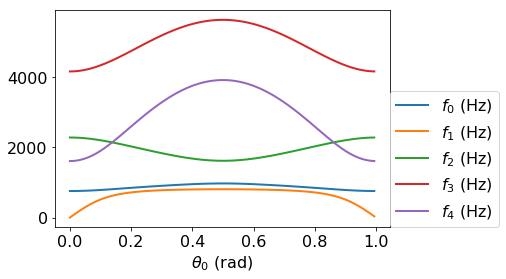

In [256]:
sub_df = df[df['$h_0$ (um)'] == 60.0]

sub_df.plot(x='$\\theta_0$ (rad)', y=['$f_{:d}$ (Hz)'.format(i) for i in range(5)], legend=False)
plt.legend(loc = (1,0))
# plt.plot(sub_df['theta_0 (rad)'], sub_df['$f_0$ (Hz)])

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

(0, 3)

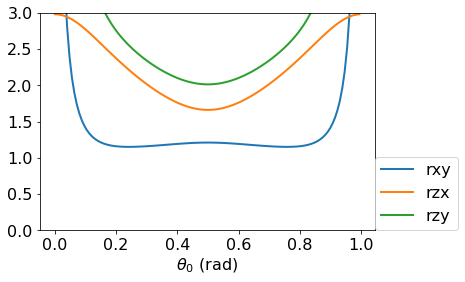

In [262]:
sub_df = df[df['$h_0$ (um)'] == 70.0]

sub_df['rxy'] = sub_df['$f_0$ (Hz)']/sub_df['$f_1$ (Hz)']
sub_df['rzx'] = sub_df['$f_2$ (Hz)']/sub_df['$f_0$ (Hz)']
sub_df['rzy'] = sub_df['$f_2$ (Hz)']/sub_df['$f_1$ (Hz)']

# sub_df.plot(x='$h_0$ (um)', y=['$f_{:d}$ (Hz)'.format(i) for i in range(3)], legend=False)
sub_df.plot(x='$\\theta_0$ (rad)', y=['rxy', 'rzx', 'rzy'], legend=False)
plt.legend(loc = (1,0))
plt.ylim([0, 3])

In [ ]:
to = df['$\\theta_0$ (rad)'].unique()[20]

sub_df = df[df['$\\theta_0$ (rad)'] == to]

sub_df['ryx'] = sub_df['$f_1$ (Hz)']/sub_df['$f_0$ (Hz)']
sub_df['rzx'] = sub_df['$f_2$ (Hz)']/sub_df['$f_0$ (Hz)']
sub_df['rzy'] = sub_df['$f_2$ (Hz)']/sub_df['$f_1$ (Hz)']

# sub_df.plot(x='$h_0$ (um)', y=['$f_{:d}$ (Hz)'.format(i) for i in range(3)], legend=False)
sub_df.plot(x='$h_0$ (um)', y=['ryx', 'rzx', 'rzy'], legend=False)
plt.legend(loc = (1,0))
# plt.ylim([0, 3e3])

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

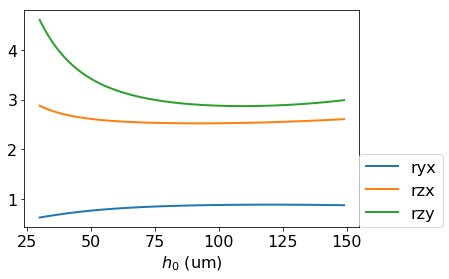

In [263]:
to = df['$\\theta_0$ (rad)'].unique()[20]

sub_df = df[df['$\\theta_0$ (rad)'] == to]

sub_df['ryx'] = sub_df['$f_1$ (Hz)']/sub_df['$f_0$ (Hz)']
sub_df['rzx'] = sub_df['$f_2$ (Hz)']/sub_df['$f_0$ (Hz)']
sub_df['rzy'] = sub_df['$f_2$ (Hz)']/sub_df['$f_1$ (Hz)']

# sub_df.plot(x='$h_0$ (um)', y=['$f_{:d}$ (Hz)'.format(i) for i in range(3)], legend=False)
sub_df.plot(x='$h_0$ (um)', y=['ryx', 'rzx', 'rzy'], legend=False)
plt.legend(loc = (1,0))
# plt.ylim([0, 3e3])

0.5013380707394703

In [37]:
frozen_dipole_model.frequencies(ho=0.3, to=0.001, physical_parameters=physical_parameters, set_y_phi_zero=True, normalization='hI', return_eq_positions = False, verbose=False)

NameError: name 'eigen_vectors' is not defined

In [ ]:
'/Users/rettentulla/PycharmProjects/frozen_dipole_model/data/from_\
mathematica_freq_map_22um.csv'
file = '../data/from_mathematica_freq_map_22um_norm_a.csv'
file = '../data/from_mathematica_freq_map_22um.csv'

# data = pd.DataFrame.from_csv(file, index_col=None)
data = pd.read_csv(file, index_col=None)

# set the initial conditions
theta_cool = 0
# theta_cool = np.pi/2
h_cool = 1.2


for q in 'xzt':
    quantity = q+'eq'
    plt.figure()
    # quantity = 'zeq'  #'yeq', zeq, teq, peq
    shape = len(np.unique(X)), len(np.unique(Y))
    X, Y = data['ho'].values, data['to'].values
    Z = data[quantity].values
    X = X.reshape(shape)
    Y = Y.reshape(shape)
    Z = Z.reshape(shape)
    # Z.reshape(X.shape)

    # create figure
    fig, axContour = plt.subplots() #figsize=(5.5, 5.5)

    # plot contour
    CS =plt.contour(X, Y, Z)
    axContour.clabel(CS, inline=1, fontsize=10, colors='k')
    
#     CS =plt.pcolor(X, Y, Z)
    CS =plt.contourf(X, Y, Z)
    cb = plt.colorbar()
    cb.set_label(quantity)

    axContour.set_xlabel('cool down height ($h_I$)')
    axContour.set_ylabel('cool down angle ($\pi$)')


    plt.draw()
    plt.show()

## 2) load from mathematica and plot

## 2.1 plot equilibrium

<Figure size 432x288 with 0 Axes>

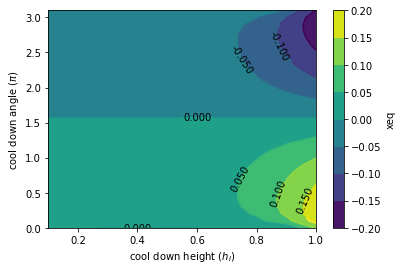

<Figure size 432x288 with 0 Axes>

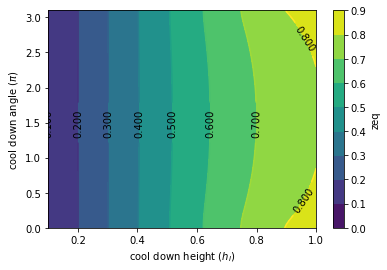

<Figure size 432x288 with 0 Axes>

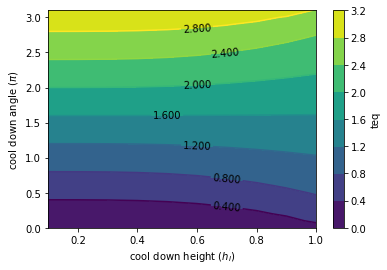

In [149]:
'/Users/rettentulla/PycharmProjects/frozen_dipole_model/data/from_\
mathematica_freq_map_22um.csv'
file = '../data/from_mathematica_freq_map_22um_norm_a.csv'
file = '../data/from_mathematica_freq_map_22um.csv'

# data = pd.DataFrame.from_csv(file, index_col=None)
data = pd.read_csv(file, index_col=None)

# set the initial conditions
theta_cool = 0
# theta_cool = np.pi/2
h_cool = 1.2


for q in 'xzt':
    quantity = q+'eq'
    plt.figure()
    # quantity = 'zeq'  #'yeq', zeq, teq, peq
    shape = len(np.unique(X)), len(np.unique(Y))
    X, Y = data['ho'].values, data['to'].values
    Z = data[quantity].values
    X = X.reshape(shape)
    Y = Y.reshape(shape)
    Z = Z.reshape(shape)
    # Z.reshape(X.shape)

    # create figure
    fig, axContour = plt.subplots() #figsize=(5.5, 5.5)

    # plot contour
    CS =plt.contour(X, Y, Z)
    axContour.clabel(CS, inline=1, fontsize=10, colors='k')
    
#     CS =plt.pcolor(X, Y, Z)
    CS =plt.contourf(X, Y, Z)
    cb = plt.colorbar()
    cb.set_label(quantity)

    axContour.set_xlabel('cool down height ($h_I$)')
    axContour.set_ylabel('cool down angle ($\pi$)')


    plt.draw()
    plt.show()

## 1.2 plot frequencies

In [160]:
file = '../data/from_mathematica_freq_map_22um_norm_a.csv'
file = '../data/from_mathematica_freq_map_22um.csv'

# data = pd.DataFrame.from_csv(file, index_col=None)
data = pd.read_csv(file, index_col=None)
data = data[data['ho']>0.5]

for i in range(5):
#     plt.figure()
    quantity = 'f'+str(i+1)  
    
    X, Y = data['ho'].values, data['to'].values
        
    shape = len(np.unique(X)), len(np.unique(Y))
    
    Z = data[quantity].values
    
    print(i, np.shape(Z.flatten()), np.sum(Z.flatten()))
    if isinstance(np.sum(Z), complex):
        print(i)
    
    Z /= (2*np.pi)*1e-3
    X = X.reshape(shape)
    Y = Y.reshape(shape)
    Z = Z.reshape(shape)



0 (160,) 151965.94706904428
1 (160,) 84642.0749526567
2 (160,) 22992.621926068517
3 (160,) 9268.582179277802
4 (160,) 7091.97049569028


<Figure size 432x288 with 0 Axes>

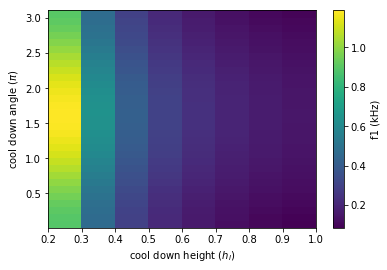

<Figure size 432x288 with 0 Axes>

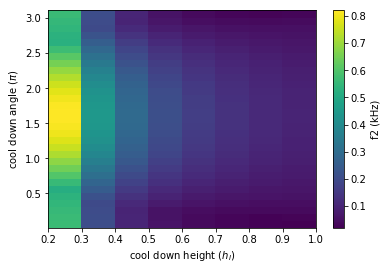

<Figure size 432x288 with 0 Axes>

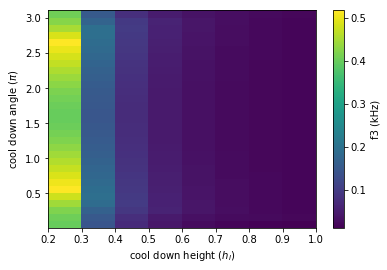

<Figure size 432x288 with 0 Axes>

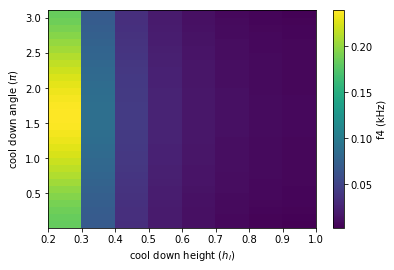

<Figure size 432x288 with 0 Axes>

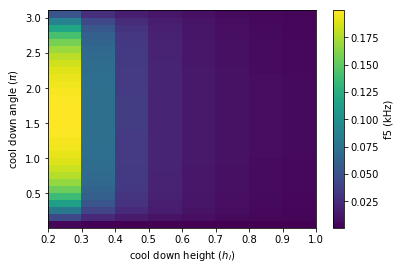

In [166]:
'/Users/rettentulla/PycharmProjects/frozen_dipole_model/data/from_\
mathematica_freq_map_22um.csv'
# file = '../data/from_mathematica_freq_map_22um_norm_a.csv'
file = '../data/from_mathematica_freq_map_22um.csv'

# data = pd.DataFrame.from_csv(file, index_col=None)
data = pd.read_csv(file, index_col=None)
data = data[data['ho']>0.1]

for i in range(5):
    plt.figure()
    quantity = 'f'+str(i+1)  
    
    X, Y = data['ho'].values, data['to'].values
    shape = len(np.unique(X)), len(np.unique(Y))
    Z = data[quantity].values / (2*np.pi)*1e-3
    X = X.reshape(shape)
    Y = Y.reshape(shape)
    Z = Z.reshape(shape)
    # Z.reshape(X.shape)

    # create figure
    fig, axContour = plt.subplots() #figsize=(5.5, 5.5)

    # plot contour
    # CS =plt.contour(X, Y, Z)
    # axContour.clabel(CS, inline=1, fontsize=10)
    CS =plt.pcolor(X, Y, Z)
    cb = plt.colorbar()
    cb.set_label(quantity + ' (kHz)')

    axContour.set_xlabel('cool down height ($h_I$)')
    axContour.set_ylabel('cool down angle ($\pi$)')

#     plt.xlim((0.5, 1))
#     plt.clim((0, 10))
    plt.draw()
    plt.show()

In [137]:
i=4
plt.figure()
quantity = 'f'+str(i+1)  
shape = len(np.unique(X)), len(np.unique(Y))
X, Y = data['ho'].values, data['to'].values
Z = data[quantity].values / (2*np.pi)*1e-3
X = X.reshape(shape)
Y = Y.reshape(shape)
Z = Z.reshape(shape)
# Z.reshape(X.shape)

# create figure
fig, axContour = plt.subplots() #figsize=(5.5, 5.5)

# plot contour
# CS =plt.contour(X, Y, Z)
# axContour.clabel(CS, inline=1, fontsize=10)
CS =plt.pcolor(X, Y, Z)
cb = plt.colorbar()
cb.set_label(quantity + ' (kHz)')

axContour.set_xlabel('cool down height ($h_I$)')
axContour.set_ylabel('cool down angle ($\pi$)')

#     plt.xlim((0.3, 1))
#     plt.clim((0, 10))
plt.draw()
plt.show()

TypeError: unsupported operand type(s) for /: 'str' and 'float'

<Figure size 432x288 with 0 Axes>

In [31]:

physical_parameters = frozen_dipole_model.default_physical_parameters
print(physical_parameters)

frozen_dipole_model.get_parameters(physical_parameters)

{'Br': 0.73, 'earth_acceleration': 9.8, 'vacuum_permeability': 1.2566370614359173e-06, 'radius': 2.25e-05, 'density': 7600}


{'Us': 8.966682075337421e-13,
 'mass_matrix': array([[3.62618332e-10, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 3.62618332e-10, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 3.62618332e-10, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.34302122e-20,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         7.34302122e-20]]),
 'A': array([[3.96318239e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 3.96318239e+03, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 3.96318239e+03, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 

In [51]:
initial_conditions = [0.2,0.8]

position_eq = frozen_dipole_model.eq_position(*initial_conditions)
position_eq, frozen_dipole_model.potential(position_eq, *initial_conditions)

(array([ 8.76168146e-05, -1.33596217e-09,  1.99866834e-01,  8.00763620e-01,
        -4.82069581e-09]), -61.69174324961706)

In [56]:
f = frozen_dipole_model.frequencies(initial_conditions[0], initial_conditions[1], physical_parameters=physical_parameters)
sorted(f)

calculating stiffness numerically, order: 2


[1138.676196048761,
 1335.833040826438,
 2952.659687181304,
 3972.3463632813514,
 6568.503671677052]

array([6738.32350163, 2859.68426117, 4219.29861596, 1364.91331951,
       1170.58756585])

In [33]:
W

array([[ 2.17877266e+08, -2.92122565e-01, -4.88662280e+04,
        -2.43077204e+07, -1.72322931e-01],
       [-2.92122565e-01,  1.67378307e+08,  1.40846372e+00,
         2.84376017e-01, -1.19848560e+07],
       [-4.88662280e+04,  1.40846372e+00,  3.86275200e+08,
         1.20033014e+07, -4.31935296e-02],
       [-7.64242323e+09,  8.94087080e+01,  3.77387544e+09,
         1.44232335e+09,  1.59448462e-01],
       [-5.41788679e+01, -3.76807616e+09, -1.35801806e+01,
         1.59448462e-01,  4.23459103e+08]])

## Compare with mathematica

In [9]:
position = [0.1, 0.2, 1, 0.4, 2]
initial_conditions = [0.1,1]

### calcualte the force (gradient) and save to file for mathematica

In [15]:

force_initial = frozen_dipole_model.force_num(position, initial_conditions[0],initial_conditions[1], verbose=True)
force_initial

../frozen_dipole_model/frozen_dipole_model.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  


array([-10.18102534,  -1.12135075,  -4.84113504,  -1.55415778,
        -1.43424033])

In [16]:


position_eq = frozen_dipole_model.eq_position(*initial_conditions)

force_initial = frozen_dipole_model.force(position, *initial_conditions)
force_initial_num = frozen_dipole_model.force_num(position, *initial_conditions)

print('Potential energy at initial position:', frozen_dipole_model.potential(position, *initial_conditions))
print('Force (gradient) at initial position:', force_initial)
print('Force (gradient) at initial position (num):', force_initial_num)

print('equilibrium position:', position_eq)
print('Potential energy at eq:', frozen_dipole_model.potential(position_eq, *initial_conditions))

print('Potential gradient at eq (num):', frozen_dipole_model.force_num(position_eq, *initial_conditions))
print('Potential gradient at eq:', frozen_dipole_model.force(position_eq, *initial_conditions))

Potential energy at initial position: -0.8841521889195141
Force (gradient) at initial position: [-10.18102534  -1.12135075  -4.84113504  -1.55415778  -1.43601934]
Force (gradient) at initial position (num): [-10.18102534  -1.12135075  -4.84113504  -1.55415778  -1.43424033]
equilibrium position: [2.36948681e-06 4.81078919e-10 9.99954441e-02 1.00003900e+00
 6.62067405e-10]
Potential energy at eq: -430.54219618678115
Potential gradient at eq (num): [ 2.78651301e-05 -4.21133459e-05  1.56217570e-05 -5.90772114e-06
  1.87486634e-06]
Potential gradient at eq: [ 2.78651204e-05 -4.21133891e-05  1.56234000e-05 -5.90772697e-06
  2.00740189e-06]


../frozen_dipole_model/frozen_dipole_model.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  


In [17]:
result = list(position)+list(initial_conditions)+list(position_eq)+list(force_initial)+list(force_initial_num)

np.savetxt("../for_mathematica.csv", result, delimiter="\t")

### Calculate the stiffness matrix and save to file for mathematica

In [20]:
k = frozen_dipole_model.stiffness_matrix_num(position_eq, *initial_conditions)

np.savetxt("../for_mathematica_stiffness.csv", k, delimiter=",")

for y in k:
    print(['{:0.3e}'.format(x) for x in y])

calculating stiffness numerically, order: 2
adaas [2.36948681e-06 4.81078919e-10 9.99954441e-02 1.00003900e+00
 6.62067405e-10]
['1.646e+05', '2.344e-05', '-1.950e+00', '-1.000e+04', '2.005e-05']
['2.344e-05', '9.380e+04', '-1.068e-03', '-3.474e-05', '-4.547e+03']
['-1.950e+00', '-1.068e-03', '-2.673e+02', '4.547e+03', '3.906e-05']
['-1.000e+04', '-3.474e-05', '4.547e+03', '1.139e+03', '-1.204e-06']
['2.005e-05', '-4.547e+03', '3.906e-05', '-1.204e-06', '4.721e+02']


In [24]:
kp = frozen_dipole_model.stiffness_matrix_num(position_eq, *initial_conditions, analytic_function='potential')


calculating stiffness numerically, order: 2


In [25]:
kf = -frozen_dipole_model.stiffness_matrix_num(position_eq, *initial_conditions, analytic_function='force')

calculating stiffness numerically, order: 2


In [28]:
for x in kf-kp:
    print(x)

[-1.64256955e-04  7.16021886e-10 -1.36562386e-08  5.77656465e-08
  1.22371229e-10]
[ 8.91002276e-10 -6.12130389e-05  4.49959537e-09 -1.59819593e-09
  2.00452632e-08]
[-1.14198047e-08 -6.36846685e-10  2.58730283e+05 -2.78160096e-05
  2.47443162e-09]
[ 5.83204383e-08 -1.60273342e-09 -2.78158896e-05  3.63888830e-09
 -3.17649647e-12]
[-1.11866917e-01  1.13762653e-05  3.31588246e-06 -8.50960313e-08
  1.32567209e-07]


# other

In [68]:
position = list(np.random.rand(3))+list(np.random.rand(2)*np.pi)+list(np.random.rand(1)*0.5+0.5)+list(np.random.rand(1)*np.pi)

, position

([0.4538861400733316,
  0.9599294401433316,
  0.7061627298102877,
  2.791046430637132,
  1.975420372386389],
 [0.6106969250853719, 1.5008051636559745],
 [0.4538861400733316,
  0.9599294401433316,
  0.7061627298102877,
  2.791046430637132,
  1.975420372386389,
  0.6106969250853719,
  1.5008051636559745])

In [25]:

# position = [0, 0, 0.7, 0, 0]
# initial_conditions = [0.1, 3]
# froze_dipole_model.potential(position, 0.1, 3)

# position_eq = froze_dipole_model.eq_position(0.1, 3)

# print('Potential energy at initial position:', froze_dipole_model.potential(position, *initial_conditions))
# print('equilibrium position:', position_eq)
# print('Potential energy at eq:', froze_dipole_model.potential(position_eq, *initial_conditions))

# print('Potential gradient at eq:', froze_dipole_model.force_num(position_eq, *initial_conditions))

x 8.968190922628856e-05
y -1.3354629931518635e-09
z 0.19987427250511877
t 0.7008039270997681
p -1.1565698254924806e-08


Text(0,0.5,'U (min max normalized)')

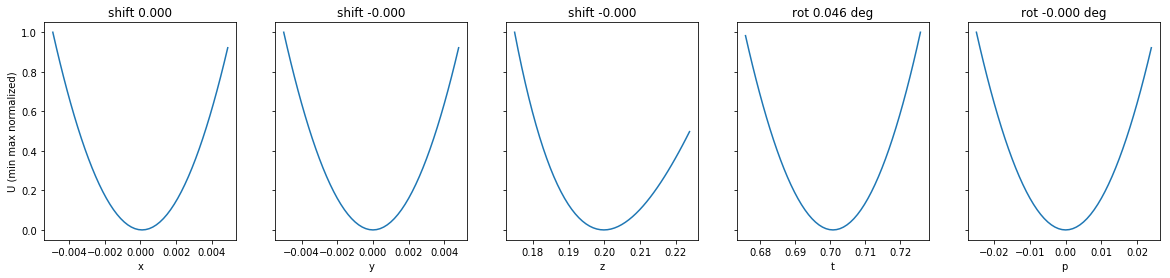

In [26]:

n = 25
dx = 0.0002


# initial_conditions = [0.5, 1]
# # froze_dipole_model.potential(position, *initial_conditions)
# position = [0, 0, initial_conditions[0], initial_conditions[1], 0]



fig, ax = plt.subplots(1, 5, figsize = (20,4), sharey=True)
for key, value in {'x':0, 'y':1, 'z':2, 't':3, 'p':4}.items():
    
    position_eq = froze_dipole_model.eq_position(*initial_conditions)
    
    print(key, position_eq[value])
    
    if key == 'z':
        dx = 1e-3
    xmin = position_eq[value]-n*dx
    xmax = position_eq[value]+n*dx
    
    if key in 'xy':
        ax[value].set_title('shift {:0.3f}'.format(position_eq[value]))
    elif key in 'z':
        ax[value].set_title('shift {:0.3f}'.format(position_eq[value]-initial_conditions[0]))
    elif key in 't':
        ax[value].set_title('rot {:0.3f} deg'.format(180/np.pi*(position_eq[value]-initial_conditions[1])))
    elif key in 'p':
        ax[value].set_title('rot {:0.3f} deg'.format(180/np.pi*(position_eq[value])))

    x = np.arange(xmin, xmax, dx)
    y = []
    for xo in x:
        position_eq[value]=xo
        y.append(froze_dipole_model.potential(position_eq, *initial_conditions))
    y = np.array(y)
    
    y -= min(y)
    y /= max(y)-min(y)
    ax[value].plot(x, y)
    ax[value].set_xlabel(key)
    
ax[0].set_ylabel('U (min max normalized)')

In [27]:
froze_dipole_model.stiffness_matrix_num(position_eq, *initial_conditions, dx=1e-11)

position_eq [ 8.96819092e-05 -1.33546299e-09  1.99874273e-01  7.00803927e-01
  2.39999884e-02]


array([[ 1.42108547e+08, -7.10542736e+07,  7.10542736e+07,
         7.10542736e+07, -7.10542736e+07],
       [-7.10542736e+07,  7.10542736e+07,  7.10542736e+07,
        -7.10542736e+07,  0.00000000e+00],
       [ 7.10542736e+07, -7.10542736e+07,  1.42108547e+08,
        -7.10542736e+07,  7.10542736e+07],
       [ 0.00000000e+00,  1.42108547e+08,  1.06581410e+08,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -7.10542736e+07,  7.10542736e+07,
        -7.10542736e+07,  7.10542736e+07]])

In [31]:
froze_dipole_model.force_num(position_eq, *initial_conditions, dx=1e-11)

[0.09094947017729282,
 -7.406697477563285,
 -0.07247535904753022,
 0.012079226507921703,
 0.8327560863108374]

In [32]:
froze_dipole_model.force(position_eq, *initial_conditions)

array([ 0.08883662, -7.40512436, -0.07493505,  0.0118374 ,  0.83218956])

In [48]:
froze_dipole_model.force(position_eq, *initial_conditions)-froze_dipole_model.force_num(position_eq, *initial_conditions, dx=1e-11)

array([-9.57608265e-06,  1.72852951e-01, -3.76556671e-05,  8.81307557e-05,
       -5.12925374e+00])

In [22]:
# def type_II_superconductor_potential(position, ho, to):
#     if len(position)==5:
#         x, y, z, t, p = position ## positions xyz and orientation theta and phi
#     if len(position)==4:
#         x, y, z, t = position ## positions xyz and orientation theta and phi
#         p=0
#     if len(position)==3:
#         x, y, z = position ## positions xyz
#         t, p = 0,0 # x, y, z, t = position ## positions xyz and orientation theta and phi
# #     ho, to = initial_consitions ## initial position height ho and angle theta (xy and phi initial are 0 due to symmetry)
    
#     denom_1 = cos(t)*((2*(ho+z)**2 - x**2 - y**2)*cos(to) - 3*x*(ho + z)*sin(to))
#     denom_2 = sin(t)*(3*(ho+z)*cos(to)*(x*cos(p)+y*sin(p))+sin(to)*(( (ho+z)**2 - 2*x**2+y**2)*cos(p) - 3*x*y*sin(p)) )
    
#     return z + (3+cos(2*t))/(6*z**3)-16*(denom_1+ denom_2) / (3*((z+ho)**2+x**2+y**2))**(5/2)
    
    
    
# def type_II_superconductor_eq_position(initial_conditions):
#     ho, to = initial_conditions ## initial position height ho and angle theta (xy and phi initial are 0 due to symmetry)

#     x0 = (0, 0, ho, to, 0)
# #     x0 = (0, 0, 0, to)
# #     x0 = (0, 0, 0)
    
#     bounds = [(-1,1), (-1,1), (-ho, 1000), (0, pi), (-pi, pi)]
# #     bounds = [(-1,1), (-1,1), (-ho, 1000), (0, pi)]
# #     bounds = [(-1,1), (-1,1), (-ho, 1000)]
# #     res = minimize(type_II_superconductor_potential, x0, args=initial_conditions, jac=type_II_superconductor_force, tol=1e-6, bounds = bounds, options = {'disp':True})
#     res = fmin(type_II_superconductor_potential, x0, args=initial_conditions, xtol=1e-6,ftol=1e-17, disp=True, maxiter=1000)
    
#     return res


# def type_II_superconductor_force_num(position, ho, to):
    
#     x, y, z, t, p = position ## positions xyz and orientation theta and phi
    
#     fx = num_diff(position, ho, to, 'x', dx=1e-9)
#     fy = num_diff(position, ho, to, 'y', dx=1e-9)
#     fz = num_diff(position, ho, to, 'z', dx=1e-9)
#     ft = num_diff(position, ho, to, 't', dx=1e-9)
#     fp = num_diff(position, ho, to, 'p', dx=1e-9)
    
#     return fx, fy, fz, ft, fp
    
    
# def type_II_superconductor_force(position, ho, to):
#     """
    
#     check with mathematica, numerical differentiation doesn't give good result (not sure if there is a bug in the coding or if it is due to numerical uncertainty)
    
#     """
    
#     x, y, z, t, p = position ## positions xyz and orientation theta and phi
    
#     denom1 = 3*cos(t)*(x*(x**2 + y**2 - 4*(ho + z)**2)*cos(to) - (ho + z)*(-4*x**2 + y**2 + (ho + z)**2)*sin(to))
#     denom2 = 3*sin(t)*(
#         (ho + z)*cos(to)*((-4*x**2 + y**2 + (ho + z)**2)*cos(p) - 5*x*y*sin(p))
#         + sin(to)*(x*(2*x**2 - 3*y**2 - 3*(ho + z)**2)*cos(p) - y*(-4*x**2 + y**2 + (ho + z)**2)*sin(p)))
#     denom = 16 * (denom1 + denom2)
#     fx = - denom / (3 * (x**2 + y**2 + (ho + z)**2)**(7/2))
    
#     denom1 =-y*cos(t)*((x**2 + y**2 - 4*(ho + z)**2)*cos(to) + 5*x*(ho + z)*sin(to))
#     denom2 =   sin(t)*(y*cos(p)*(5*x*(ho + z)*cos(to) + (-4*x**2 + y**2 + (ho + z)**2)*sin(to)) - (x**2 - 4*y**2 + (ho + z)**2)*((ho + z)*cos(to) - x*sin(to))*sin(p))
#     denom = denom1 + denom2
#     fy = denom / ((x**2 + y**2 + (ho + z)**2)**(7/2))
    
#     t1 = 1 - 3/(2*z**4) -  cos(2*t)/(2*z**4)
#     denom1 = cos(t)*((ho + z)*(-3*(x**2 + y**2) + 2*(ho + z)**2)*cos(to) + x*(x**2 + y**2 - 4*(ho + z)**2)*sin(to))
#     denom2 = sin(t)*(-(x**2 + y**2 -4*(ho + z)**2)*cos(to)*(x*cos(p) +y*sin(p)) + (ho +z)*sin(to)*((-4*x**2 + y**2 + (ho + z)**2)*cos(p) -5*x*y*(sin(p))))
#     t2 = 16/(x**2 + y**2 + (ho + z)**2)**(7/2)*(denom1 + denom2)
#     fz = t1 + t2

#     t1 = -(sin(2*t)/(3*z**3))
#     denom1 = sin(t)*((x**2 + y**2 - 2*(ho + z)**2)*cos(to) + 3*x*(ho + z)*sin(to))
#     denom2 = cos(t)*(3*(ho + z)*cos(to)*(x*cos(p) + y*sin(p)) + sin(to)*((-2*x**2 + y**2 + (ho + z)**2)*cos(p) - 3*x*y*sin(p)))
#     t2 = -16/(3*(x**2 + y**2 + (ho + z)**2)**(5/2))*(denom1 + denom2)
#     ft = t1 + t2

#     denom = sin(t)*(-3*(ho + z)*cos(to)*(y*cos(p) -x*sin(p)) + sin(to)*(3*x*y*cos(p) + (-2*x**2 + y**2 + (ho + z)**2*sin(p))))
#     fp = 16/(3*(x**2 + y**2 + (ho + z)**2)**(5/2)) * denom1

#     return np.array([fx, fy, fz, ft, fp])

# def num_diff(position, ho, to, x, dx=1e-5):
    
#     x_to_num = {'x':0,'y':1, 'z':2, 't':3, 'p':4}
#     if isinstance(x, str):
#         x = x_to_num[x]
#     p1 = np.array(position)
#     p1[x] -= dx
    
#     p2 = np.array(position)
#     p2[x] += dx
    
# #     print(p1)
# #     print(p2)
    
#     x1 = type_II_superconductor_potential(p1, ho, to)
#     x2 = type_II_superconductor_potential(p2, ho, to)

# #     print(x1)
# #     print(x2)

    
#     return (x2-x1)/dx

                                                                                                          

# # def type_II_superconductor_stiffness(position, initial_consitions):

# def type_II_superconductor_frequencies(initial_consitions):
#     equilibrium = type_II_superconductor_eq_position(initial_consitions)

    
    
# def numerical_derivative(function, point, args, order=1, epsilon=1e-10):
#     """
#     Finds the nth derivative of a 3D scalar function numerically, using the finite
#     difference formulas found at the following url:
#     https://en.wikipedia.org/wiki/Finite_difference_coefficient
#     """

#     # coefficients of numerical derivatieves for orders 1 through 4,
#     # in the form of a list of tuples (grid_position, coefficient)
#     if order == 0:
#         function_value = function(point, *args)
#         return np.array([function_value, function_value, function_value])
#     elif order == 1:
#         coeffs = np.array([[-1,-0.5], [0,0], [1,0.5]])
#     elif order == 2:
#         coeffs = np.array([[-1, 1], [0,-2], [1, 1]])
#     elif order == 3:
#         coeffs = np.array([[-2, -0.5], [-1, 1], [0,0], [1, -1], [2, 0.5]])
#     elif order == 4:
#         coeffs = np.array([[-2, 1], [-1, -4], [0, 6], [1, -4], [2, 1]])
#     else:
#         print('Can only do zeroth through fourth derivative')
#         raise ValueError
    

#     # Get vectors for small steps in x, y, and z
#     tiny_x_step, tiny_y_step, tiny_z_step, tiny_t_step, tiny_p_step = epsilon*np.eye(5)

#     finite_difference_x = np.sum([coeff * function(point + tiny_x_step*grid_pos, *args)
#           for grid_pos, coeff in coeffs if coeff], axis=0)

#     finite_difference_y = np.sum([coeff * function(point + tiny_y_step*grid_pos, *args)
#           for grid_pos, coeff in coeffs if coeff], axis=0)

#     finite_difference_z = np.sum([coeff * function(point + tiny_z_step*grid_pos, *args)
#           for grid_pos, coeff in coeffs if coeff], axis=0)

#     finite_difference_t = np.sum([coeff * function(point + tiny_t_step*grid_pos, *args)
#           for grid_pos, coeff in coeffs if coeff], axis=0)
    
#     finite_difference_p = np.sum([coeff * function(point + tiny_p_step*grid_pos, *args)
#           for grid_pos, coeff in coeffs if coeff], axis=0)
    
#     return np.transpose([finite_difference_x, finite_difference_y, finite_difference_z, finite_difference_t, finite_difference_p])/(epsilon**order)

In [33]:
numerical_derivative(type_II_superconductor_potential, position, initial_consitions, order=2, epsilon=1e-8)

NameError: name 'numerical_derivative' is not defined

In [244]:
type_II_superconductor_force(position, *initial_consitions)

array([  0.7905606 ,   0.        , -42.09196453,  -0.34257626,
         0.        ])

In [247]:
initial_consitions = (0.1, 3)
position_eq = type_II_superconductor_eq_position(initial_consitions)
print(position_eq)
print(type_II_superconductor_potential(position_eq, *initial_consitions))
print(type_II_superconductor_potential(position_guess, *initial_consitions))

Optimization terminated successfully.
         Current function value: -7.951606
         Iterations: 786
         Function evaluations: 1389
[-6.59319114e-02  2.77957752e-09  2.77761839e-01  2.34820852e+00
 -3.08660785e-08]
-7.951605899375462
-0.6987563324785264


In [239]:
position_guess = [0,0,initial_consitions[0],initial_consitions[1], 0]

(0.3042872620540038, 0.0, -66.26929938136072, -0.1318571918318412, 0.0)

In [170]:
type_II_superconductor_force(position, *initial_consitions)

(-0.0, 0.0, 215.9135802469136, -0.0, -0.0)

In [171]:
type_II_superconductor_force(position, *initial_consitions)

(-0.0, 0.0, 215.9135802469136, -0.0, -0.0)

In [172]:
 type_II_superconductor_potential(position, *initial_consitions)

-3.6703748014753197

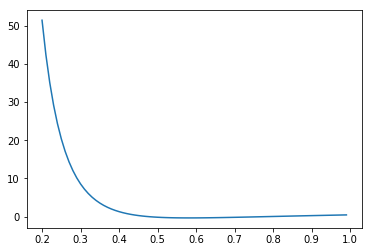

In [173]:
def f(x):
    
    position = [0,0,x, 0,0]
    initial_consitions = (0.2, 0)
    return type_II_superconductor_potential(position, *initial_consitions)
    
x = np.arange(0.2,1,0.01)

plt.plot(x, f(x))
# f(x), x

ValueError: length of x0 != length of bounds